In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import time
import io
import datetime
import sys
pd.set_option('max_colwidth',150)
%matplotlib inline

### Get the name of the rdf files, parse and save them in dataFrames

In [2]:
rdf1 ='1_Navigation 100% adaptable et fiable.rdf'
rdf2 = '3_Systèmes apprenants parfaitement robustes.rdf'
rdf3 = '4_R&D intégrée Flash.rdf'

In [3]:
def cleanCollections(hirarchy,collections):
    dic=dict(hirarchy)
    for value in collections.values():
        counter=0
        if value in hirarchy.keys():
            counter+=1
        else:
            for listValue in hirarchy.values():
                if value in listValue:
                    counter+=1
        if counter==0:
            dic[value]=[value]
    return dic      

In [4]:
def findParent(classe,dic):
    find=False
    # check if classe has parent 
    for key,value in dic.items():
        if classe in value:
            find=True
            return key
        else:
            pass
    # if it did not find then it is an independent class
    if find==False:
        return classe

In [5]:
# this function parse the rdf file and extract the title, abstract, url and the name of the first author
def ParseRDF(rdfFile):
    rdf = open(rdfFile,encoding="utf-8")
    soup = BeautifulSoup(rdf, 'xml')
    collections=soup.findAll('z:Collection')
    #for collection in collections:
        #print(collection.title.text,'\n')
  
   # get the id and the title of each collection 
    DiCollection={}
    for collection in collections:
        DiCollection[collection['rdf:about']]=collection.title.text
    #print(DiCollection)
  # Build the hirarchy of the collections  
    Collection_hirarchy={}
        # get each extracted collection
    for collection in collections:
        # get all sub part of this collection
        subEllement=collection.find_all(name='dcterms:hasPart')
        listColl=[]
        for sub in subEllement:    
            # verify if the sub parts of this collection is collection or not
            if sub['rdf:resource'].startswith("#collection_"):
                if sub['rdf:resource'] in DiCollection.keys():
                    if DiCollection[sub['rdf:resource']] not in listColl:
                                    listColl.append(DiCollection[sub['rdf:resource']])
        if listColl:               
            Collection_hirarchy[collection.title.text]=listColl 
            
    # verify if there collection have not been aded
    dic=cleanCollections(Collection_hirarchy,DiCollection)        
    print(dic)  
    
    # Trouver les articles
    artilces= soup.findAll('Article')
    #len(articles_1)
    liste = []
    for article in artilces:
        subject = article.findAll(name ='dc:subject')
        #print(subject)
        
        # get the title of the article
        if article.find(name='dc:title', recursive=False):
            title=article.find(name='dc:title', recursive=False)
            title=title.text
        #print(title)
        else:
            title="None"
            
        # get the abstract    
        if article.abstract:
            abstract=article.abstract.text
        else :
            #Quand il n'y a pas d'abstract, on récupère tous les subjects présents
            if article.find(name='dc:subject') :
                subject = article.find_all('dc:subject')
                #len(subject)
                for sub in subject: 
                    #print(sub.text)
                    abstract = " "
                    abstract = abstract + " " + sub.text
                #print(abstract)

            else :
                abstract="None"
            
        # get the url or id of this article  
        if article['rdf:about']:
            url=article['rdf:about']
        else:
            url="None"
       # get first author
        if article.Person:
            Auteur = article.Person.text
        else:
            Auteur = "None"
     # get all collections 
        for collection in collections:
            # get each sub tag in each collection
            subEllement=collection.find_all(name='dcterms:hasPart')
            for sub in subEllement:
            # verify if the sub parts of this collection contain the url of this article or not
                if sub['rdf:resource']==url:
                    # get the name of the collection
                    classe=collection.title.text
        # find the parent collection of the current one            
        parent=findParent(classe,dic)            
        
        if abstract!='None':
            liste.append([title,abstract,url, Auteur,classe,parent])
    #liste
    df = pd.DataFrame(liste, columns = ['Titre','Resume','URL','Auteur','Class','ParentClass'])
    return df,dic

In [6]:
df1,collection1=ParseRDF(rdf1)
df1.head(5)

{'Navigation hybride': ['Baromètre'], 'Radiologie interventionelle': ['Active catheter', 'Fibre Optique FBG', 'Laser detection', 'Model Order Reduction', 'RI', 'Techniques opératoires'], 'RI': ['Multi Sensor Data Fusion']}


Titre  \
0                                                                  The basics of intravascular optical coherence tomography   
1                                             An eﬃcient orientation ﬁlter for inertial and inertial/magnetic sensor arrays   
2                                       Laser-Machined Shape Memory Alloy Sensors for Position Feedback in Active Catheters   
3  Simultaneous tracking of catheters and guidewires: comparison to standard fluoroscopic guidance for arterial cannulation   
4                                                 Development of Active Catheter,Active Guide Wire and Micro Sensor Systems   

                                                                                                                                                  Resume  \
0  Optical coherence tomography (OCT) has opened new horizons for intravascular coronary imaging. It utilizes near-infrared light to provide a micros...   
1  This report presents a novel orientation ﬁlter applicable to IMUs consisting of tri-axis gyroscopes and accelerometers, and MARG sensor arrays tha...   
2  Catheter-based interventions are a form of minimally invasive surgery that can decrease hospitalization time and greatly lower patient morbidity c...   
3  OBJECTIVES: The purpose of this in vitro study was to clinically assess the feasibility of a three-dimensional (3D) electromagnetic (EM) navigator...   
4  Active catheters and active guide wires which move like a snake have been developed for catheter-based minimally invasive diagnosis and therapy. C...   

                                                     URL  \
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4495121/   
1                                              #item_204   
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2598764/   
3                                              #item_226   
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3627230/   

                        Auteur                     Class  \
0          \nRoleder\nTomasz\n           Active catheter   
1  \nMadgwick\nSebastian O H\n  Multi Sensor Data Fusion   
2       \nTung\nAlexander T.\n           Active catheter   
3              \nCondino\nS.\n           Active catheter   
4                 \nHaga\nY.\n           Active catheter   

                   ParentClass  
0  Radiologie interventionelle  
1                           RI  
2  Radiologie interventionelle  
3  Radiologie interventionelle  
4  Radiologie interventionelle

In [7]:
df1.shape

(28, 6)

In [8]:
df1.isnull().any()

Titre          False
Resume         False
URL            False
Auteur         False
Class          False
ParentClass    False
dtype: bool

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 6 columns):
Titre          28 non-null object
Resume         28 non-null object
URL            28 non-null object
Auteur         28 non-null object
Class          28 non-null object
ParentClass    28 non-null object
dtypes: object(6)
memory usage: 1.4+ KB


In [10]:
#df1.to_csv("rdf1.csv",index=False)

In [11]:
len(collection1.keys())

3

In [12]:
df2,collection2=ParseRDF('3_Systèmes apprenants parfaitement robustes.rdf')
df2.head(5)

{'G3P-Gravityless3Printing': ["IA pour régulation d'impression 3D", 'Polymères', 'Propriétés mécaniques Parois Vaisseaux', "Technologies d'impression additive en phase liquide"], "IA pour régulation d'impression 3D": ['Artefact de test', 'Généralités', 'Imprimabilité', 'Influence des paramètres', 'Machine Learning VS control theory', 'Monitoring impression', 'Printing problems'], 'Monitoring impression': ['Par Problème', 'Par Technologie'], 'Par Problème': ['Buse bouchée', 'Défauts géométriques', 'Délamination', 'Dépôt du filament', 'Pièce détachée', 'Précision déplacements', 'Warping'], 'Par Technologie': ['Acoustique', 'Caméra Thermique', 'Contraintes', 'Contrôle BF des actionneurs', 'Courant', 'Multi-capteurs', 'Scanner Laser', 'Ultrasons', 'Vibrations', 'Vision'], 'AAP Covid19 armées': ['AAP Covid19 armées'], 'Segmentation MMB': ['Segmentation MMB']}


Titre  \
0                                                                                                     COMMON FDM 3D PRINTING DEFECTS   
1                           Closed-loop control of variable layer width for thin-walled parts in wire and arc additive manufacturing   
2  Additive manufacturing process monitoring and control by non-destructive testing techniques: challenges and in-process monitoring   
3                                                                A Layer-To-Layer Model and Feedback Control of Ink-Jet 3-D Printing   
4                                                                                  (71) Applicant: Voxel8, Inc.. Somerville, MA (US)   

                                                                                                                                                  Resume  \
0  Rapid prototyping (RP) is a group of 3D printing techniques aiming design verification, visualization, and kinematic functionality testing, which ...   
1  An intelligent single-neuron self-adjusting controller is proposed for variable layer width control in wire and arc additive manufacturing (WAAM)....   
2  This paper examines on the obstacles specific to the implementation of non-destructive testing (NDT) techniques in additive manufacturing (AM). Th...   
3  Ink-jet 3-D printing is a promising additive manufacturing technology with the potential for impacting a wide variety of industries. In typical in...   
4  A three-dimensional (3D) printer and method of 3D printing including receiving a 3D model of an object tO be printed, receiving information includ...   

                                                              URL  \
0                                                         #item_6   
1  https://linkinghub.elsevier.com/retrieve/pii/S0924013616300516   
2                   https://doi.org/10.1080/17452759.2017.1351201   
3                                                        #item_49   
4                                                        #item_58   

                         Auteur                  Class  \
0             \nGünayd\nKadir\n      Printing problems   
1                \nXiong\nJun\n  Monitoring impression   
2                 \nLu\nQ. Y.\n  Monitoring impression   
3                    \nLu\nLu\n  Monitoring impression   
4  \nSomerville\nJohn Minardi\n  Monitoring impression   

                          ParentClass  
0  IA pour régulation d'impression 3D  
1  IA pour régulation d'impression 3D  
2  IA pour régulation d'impression 3D  
3  IA pour régulation d'impression 3D  
4  IA pour régulation d'impression 3D

In [13]:
df2.shape

(137, 6)

In [14]:
len(collection2.keys())

7

In [15]:
df3,collection3=ParseRDF('4_R&D intégrée Flash.rdf')
df3.head(5)

{'R&D_intégrée': ['ARES medica R&D intégrée', 'autre revue et biblio', 'biblio EV_vanhouck', 'Biblio KPI EV', 'Contribution1 onthologie', 'EDC2020.3.10_Comment opérer une analyse multi-critères de la valeur d’un ensemble d’items comparés par paires ?\u200b  \u200b', "EDC2020.3.14 Quelles sont les conditions pour équilibrer ouverture et réfutation lors d'un échange scientifique.", 'Efficience en recherche', "Etat de l'art model de maturité", 'evaluation de la recherche modèle CSDS', 'EVMS', 'Global_Expé_2020', 'maturité pour la recherche', 'ontologie', 'R&D management'], 'ARES medica R&D intégrée': ['Cybernetics and IA problem solving', 'Earned value'], 'Biblio KPI EV': ['Calcul EV'], 'EVMS': ['RAKE']}


Titre  \
0                                A study of the R&D efficiency and productivity of Chinese firms   
1                    A model for effective implementation of Earned Value Management methodology   
2                                    Assisting R&D activities definition through problem mapping   
3  Modeling a Paradigm Shift: From Producer Innovation to User and Open Collaborative Innovation   
4             Practice Led Research: Creative Activity, Academic Debate, and Intellectual Rigour   

                                                                                                                                                  Resume  \
0                                                                                                                         Stochastic frontier estimation   
1  For better implementation of Earned Value Management (EVM) methodology in different types of organizations and projects (e.g. public and private; ...   
2  Problem formulation and problem solving has always been identified as a key activity in design, moreover in the context of innovation. Nevertheles...   
3  In this paper, we assess the economic viability of innovation by producers relative to two increasingly important alternative models: innovations ...   
4  By focussing on PhD supervision as well as creativity, this paper explores how the artefact and exegesis PhD offers an opportunity to bring creati...   

                                                                  URL  \
0       http://linkinghub.elsevier.com/retrieve/pii/S0147596703000556   
1  http://www.sciencedirect.com/science/article/pii/S0263786302000492   
2  http://www.sciencedirect.com/science/article/pii/S1755581708000503   
3        http://pubsonline.informs.org/doi/abs/10.1287/orsc.1100.0618   
4     http://www.ccsenet.org/journal/index.php/hes/article/view/16403   

                  Auteur                    Class   ParentClass  
0      \nZhang\nAnming\n  Efficience en recherche  R&D_intégrée  
1       \nKim\nEunHong\n                     EVMS  R&D_intégrée  
2  \nCavallucci\nDenis\n    autre revue et biblio  R&D_intégrée  
3   \nBaldwin\nCarliss\n    autre revue et biblio  R&D_intégrée  
4      \nArnold\nJosie\n    autre revue et biblio  R&D_intégrée

In [16]:
len(collection3.keys())

4

In [17]:
df3.shape

(226, 6)

In [18]:
df = pd.concat([df1,df2,df3])
df.head(3)

Titre  \
0                             The basics of intravascular optical coherence tomography   
1        An eﬃcient orientation ﬁlter for inertial and inertial/magnetic sensor arrays   
2  Laser-Machined Shape Memory Alloy Sensors for Position Feedback in Active Catheters   

                                                                                                                                                  Resume  \
0  Optical coherence tomography (OCT) has opened new horizons for intravascular coronary imaging. It utilizes near-infrared light to provide a micros...   
1  This report presents a novel orientation ﬁlter applicable to IMUs consisting of tri-axis gyroscopes and accelerometers, and MARG sensor arrays tha...   
2  Catheter-based interventions are a form of minimally invasive surgery that can decrease hospitalization time and greatly lower patient morbidity c...   

                                                     URL  \
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4495121/   
1                                              #item_204   
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2598764/   

                        Auteur                     Class  \
0          \nRoleder\nTomasz\n           Active catheter   
1  \nMadgwick\nSebastian O H\n  Multi Sensor Data Fusion   
2       \nTung\nAlexander T.\n           Active catheter   

                   ParentClass  
0  Radiologie interventionelle  
1                           RI  
2  Radiologie interventionelle

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 225
Data columns (total 6 columns):
Titre          391 non-null object
Resume         391 non-null object
URL            391 non-null object
Auteur         391 non-null object
Class          391 non-null object
ParentClass    391 non-null object
dtypes: object(6)
memory usage: 21.4+ KB


In [20]:
df.shape

(391, 6)

In [21]:
df.to_csv('allRDF.csv',index=False)

In [22]:
len(df.ParentClass.unique())

11

In [23]:
len(df.Auteur.unique())

316

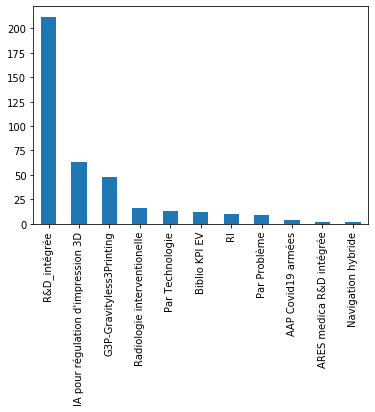

In [24]:
df.ParentClass.value_counts().plot.bar()

#### Save all the collections in one json file for later use

In [25]:
Dic_collections={rdf1:collection1,rdf2:collection2,rdf3:collection3}

In [26]:
import json

with open('Collections.json', 'w', encoding='utf8') as fp:
    json.dump(Dic_collections,fp,indent=4,ensure_ascii=False)

## 2. Clean the extracted info

In [27]:
df.Resume[0]

0    Optical coherence tomography (OCT) has opened new horizons for intravascular coronary imaging. It utilizes near-infrared light to provide a micros...
0    Rapid prototyping (RP) is a group of 3D printing techniques aiming design verification, visualization, and kinematic functionality testing, which ...
0                                                                                                                           Stochastic frontier estimation
Name: Resume, dtype: object

In [28]:
df_abstract=pd.DataFrame(df)
df_abstract.shape

(391, 6)

In [29]:
df_titleAbstract=pd.DataFrame(df)
df_titleAbstract.shape

(391, 6)

In [30]:
import nltk
from nltk.stem.snowball import FrenchStemmer
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
import scipy.sparse
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#stemmer = FrenchStemmer()
tokenizer = nltk.RegexpTokenizer(r'\w+')
stop_fr = nltk.corpus.stopwords.words('french')
stop_uk = nltk.corpus.stopwords.words('english')
stop_spacy_fr = list(fr_stop)

#### this function clean the title and the abstract of each article, by deleting non letters and stop words. Then concat them in a new column 'BageOfWords' which contains only the nouns

In [31]:
# On crée une fonction qu'on appliquera à l'ensemble des lignes
def nettoyage(x):
    text=str(x)
    # tokenize the text
    text = tokenizer.tokenize(text.lower())
    #  text = word_tokenize(text.lower())
    text = [word for word in text if not word in stop_fr]
    text = [word for word in text if not word in stop_uk]
    text = [word for word in text if not word in stop_spacy_fr]
    # delete not chars
    text=[word for word in text if word.isalpha()]
    # keep words with length more than 2 chars
    text=[word for word in text if len(word)>2]
    return " ".join(text)

In [32]:
def concattitreResume(title,abstract):
    concatWords=nettoyage(title)+" "+nettoyage(abstract)
    nouns = [token for token, pos in nltk.pos_tag(nltk.word_tokenize(concatWords)) if pos.startswith('N')]
    return " ".join(nouns)

In [33]:
def ExtractBOW(abstract):
    BOW=nettoyage(abstract)
    nouns = [token for token, pos in nltk.pos_tag(nltk.word_tokenize(BOW)) if pos.startswith('N')]
    return " ".join(nouns)

###### This function clean author name from newline symbols

In [34]:
def nettoyageAuteur(x):
    # delete newline from the first and the end of author name
    t=x.strip()
    # delete newline in the middel of author name
    t= t.replace("\n", " ")
    return t

#### Clean and generate BOW from just the abstract

In [35]:
df_abstract.Auteur=df_abstract.Auteur.apply(lambda x: nettoyageAuteur(x))

In [36]:
df_abstract['BagOfWords'] = df_abstract.apply(lambda x: ExtractBOW(x.Resume), axis=1)

In [37]:
df_abstract.Resume[0]

0    Optical coherence tomography (OCT) has opened new horizons for intravascular coronary imaging. It utilizes near-infrared light to provide a micros...
0    Rapid prototyping (RP) is a group of 3D printing techniques aiming design verification, visualization, and kinematic functionality testing, which ...
0                                                                                                                           Stochastic frontier estimation
Name: Resume, dtype: object

In [38]:
df_abstract.BagOfWords[0]

0    coherence tomography oct horizons imaging provide microscopic pathology arteries coherence tomography composition plaques traits vulnerability too...
0    group techniques design verification visualization functionality methods laser sls deposition stereolithography printing printing method methods p...
0                                                                                                                                               estimation
Name: BagOfWords, dtype: object

In [39]:
df_abstract.isnull().any()

Titre          False
Resume         False
URL            False
Auteur         False
Class          False
ParentClass    False
BagOfWords     False
dtype: bool

#### Clean & generate BOW from title and abstract

In [40]:
df_titleAbstract.Auteur=df_titleAbstract.Auteur.apply(lambda x: nettoyageAuteur(x))

In [41]:
df_titleAbstract['BagOfWords'] = df_titleAbstract.apply(lambda x: concattitreResume(x.Titre, x.Resume), axis=1)

In [42]:
df_titleAbstract.Resume[0]

0    Optical coherence tomography (OCT) has opened new horizons for intravascular coronary imaging. It utilizes near-infrared light to provide a micros...
0    Rapid prototyping (RP) is a group of 3D printing techniques aiming design verification, visualization, and kinematic functionality testing, which ...
0                                                                                                                           Stochastic frontier estimation
Name: Resume, dtype: object

In [43]:
df_titleAbstract.Titre[0]

0           The basics of intravascular optical coherence tomography
0                                     COMMON FDM 3D PRINTING DEFECTS
0    A study of the R&D efficiency and productivity of Chinese firms
Name: Titre, dtype: object

In [44]:
df_titleAbstract['BagOfWords'][0]

0    basics coherence tomography coherence tomography oct horizons imaging provide microscopic pathology arteries coherence tomography composition plaq...
0    fdm printing defects group techniques design verification visualization functionality methods laser sls deposition stereolithography printing prin...
0                                                                                                           study efficiency productivity firms estimation
Name: BagOfWords, dtype: object

In [45]:
df_titleAbstract.isnull().any()

Titre          False
Resume         False
URL            False
Auteur         False
Class          False
ParentClass    False
BagOfWords     False
dtype: bool

### Save the cleaned dataFrames in pickles

In [46]:
df_abstract.to_pickle("df_Abstract_supervised.pkl")

In [47]:
df_titleAbstract.to_pickle("df_titleAbstract_supervised.pkl")